# Velocity-Verlet Implementation with Langevin thermostat

$$ c_0 = e^{-\gamma \Delta t} \ , \ c_1 = \frac{1}{\gamma \Delta t} (1-c_0) \ , \ c_2 = \frac{1}{\gamma \Delta t} (1-c_1) \ , \ c_3 = \frac{1}{\gamma \Delta t} (\frac{1}{2}-c_2) $$

$$ x(t+\Delta t) = x(t) + c_1 v(t) \Delta t + c_2 a(t) \Delta t^2 $$

$$ v(t+\Delta t) = c_0 v(t) + (c_1-c_2) a(t) \Delta t + c_2 a(t+\Delta t) \Delta t $$


In [10]:
import numpy as np
import matplotlib.pyplot as plth
import matplotlib.pylab as plt
import math
from IPython import display
import time

In [11]:
params = {
    "natoms" : 10000, "temp"   : 300,"mass"   : 0.001,"radius" : 120e-12,"relax"  : 5e-13,"dt"     : 1e-15,
    "nsteps" : 1000,"freq"   : 100,"box"    : ((0, 1e-8), (0, 1e-8), (0, 1e-8))
}
Avogadro = 6.02214086e23
Boltzmann = 1.38064852e-23

In [12]:
def ComputeForce(mass_grp,vels,temp,relax,dt):
    
    natoms,dimension=vels.shape
    
    sigma = np.sqrt(2.0 * mass_grp * temp * Boltzmann / (relax * dt))
    random_force = np.random.randn(natoms,dimension) * sigma[:,np.newaxis]
    net_force = -(vels * mass_grp[:,np.newaxis]) / relax + random_force
    return random_force,net_force

In [13]:
def integrate(positions,forces,vels,acc,relax,dt,mass_grp,c0,c1,c2,c3):
    
    positions += c1*vels *dt + c2* acc * dt * dt
    vels = vels*c0 + (c1-c2)*acc*dt + c2 * dt * (forces / mass_grp[:,np.newaxis])
    acc = forces / mass_grp[:,np.newaxis]

In [14]:
def CheckBoundary(positions,vels,box,dimension):
    
    for i in range(dimension):
        vels[((positions[:,i] <= box[i][0]) | (positions[:,i] >= box[i][1])),i] *= -1

In [15]:
def run(natoms,temp,mass,radius,relax,dt,nsteps,freq,box):
    
    global trajectory    
    dimension=len(box)
    positions=np.random.rand(natoms,dimension)
    for i in range(dimension):
        positions[:,i] = box[i][0] + (box[i][1]-box[i][0]) * positions[:,i]
    
    mass_in_kg=mass/Avogadro
    sigma_boltz=np.sqrt(Boltzmann*temp/mass_in_kg)
    vels=np.random.randn(natoms,dimension)*sigma_boltz
#    vels=np.random.rand(natoms,dimension)

    c0=np.exp(-dt/relax)
    c1=(relax/dt)*(1-c0)
    c2=(relax/dt)*(1-c1)
    c3=(relax/dt)*(0.5-c2)
    
    acc=np.zeros((natoms,dimension))
    
    mass_grp=np.ones(natoms) * mass / Avogadro
    radius_grp=np.ones(natoms) * radius
    step=0    
    output=[]
    
    while step <= nsteps:       
        #Compute forces
        noise,forces=ComputeForce(mass_grp,vels,temp,relax,dt)
            #time iteration
        integrate(positions,forces,vels,acc,relax,dt,mass_grp,c0,c1,c2,c3)
            #Boundary conditions
        CheckBoundary(positions,vels,box,dimension)
            #Calculate Temperature
        inst_temperature = np.sum(np.dot(mass_grp,(vels-vels.mean(axis=0))**2)/(natoms*Boltzmann*dimension))
        output.append([step*dt,inst_temperature])       
        step += 1     
            #For dynamic plots
#         plt.plot(np.array(output)[:,0]*1e12,np.array(output)[:,1])
#         plt.plot(positions[:,0],positions[:,1],'ro')
#         plt.ylim([-20,350])
#         plt.xlim([-1,10])
#         display.clear_output(wait=True)
#         display.display(plt.gcf())
#         time.sleep(0.001)
    return np.array(output),vels

In [16]:
out1,out2=run(**params)

### Temperature

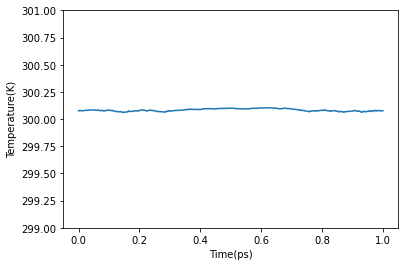

In [22]:
plt.xlabel("Time(ps)")
plt.ylabel("Temperature(K)")
plt.plot(out1[:,0]*1e12,out1[:,1])
plt.ylim(299,301)
plt.show()

### Speed Distribution (Maxwell - Boltzmann Dist.)

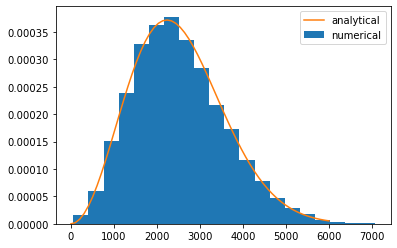

In [18]:
mass_in_kg=params["mass"]/Avogadro
sigma_boltz=np.sqrt(Boltzmann*params["temp"]/mass_in_kg)
speed=np.sqrt(out2[:,0]**2+out2[:,1]**2+out2[:,2]**2)
plth.hist(speed,bins=20,density=True,label="numerical")
x=np.linspace(0,6000,60)
y=4*np.pi*x**2*((mass_in_kg/(2*np.pi*Boltzmann*params["temp"]))**(3/2))*np.exp((-mass_in_kg*x**2)/(2*Boltzmann*params["temp"]))
plth.plot(x,y,label="analytical")
plth.legend(loc="upper right")
plth.show()